In [1]:
import os
import pickle
import config
import dnnlib
import gzip
import json
import numpy as np
from tqdm import tqdm_notebook
import warnings
import matplotlib.pylab as plt
%matplotlib inline
warnings.filterwarnings("ignore")

# Loading data

In [2]:
# Thanks for Microsoft Cognitive Services API (free trial) for labeling of generated images
# https://azure.microsoft.com/en-us/services/cognitive-services/face/

# A pretty simple logic was used for generating images:

# qlatents = np.random.normal(size=(1, 512))
# dlatents = Gs_network.components.mapping.run(qlatents, None, minibatch_size=1, randomize_noise=False, structure='fixed') # untruncated by default, I guess
# images = Gs_network.components.synthesis.run(dlatents, minibatch_size=1, randomize_noise=False, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), structure='fixed')

# After that generated image was sent to Micriosft API and response was stored as is

In [3]:
LATENT_TRAINING_DATA = 'https://drive.google.com/uc?id=1xMM3AFq0r014IIhBLiMCjKJJvbhLUQ9t'
    
with dnnlib.util.open_url(LATENT_TRAINING_DATA, cache_dir=config.cache_dir) as f:
    qlatent_data, dlatent_data, labels_data = pickle.load(gzip.GzipFile(fileobj=f))

    
labels_data[0]  # wow. many fields. amaze

{'faceId': 'b6807d9a-0ab5-4595-9037-c69c656c5c38',
 'faceRectangle': {'top': 322, 'left': 223, 'width': 584, 'height': 584},
 'faceLandmarks': {'pupilLeft': {'x': 386.0, 'y': 480.7},
  'pupilRight': {'x': 641.7, 'y': 481.1},
  'noseTip': {'x': 518.0, 'y': 648.1},
  'mouthLeft': {'x': 388.9, 'y': 748.0},
  'mouthRight': {'x': 645.1, 'y': 741.8},
  'eyebrowLeftOuter': {'x': 304.3, 'y': 441.0},
  'eyebrowLeftInner': {'x': 466.8, 'y': 442.9},
  'eyeLeftOuter': {'x': 345.4, 'y': 485.3},
  'eyeLeftTop': {'x': 385.2, 'y': 464.8},
  'eyeLeftBottom': {'x': 386.5, 'y': 497.1},
  'eyeLeftInner': {'x': 424.6, 'y': 487.6},
  'eyebrowRightInner': {'x': 572.8, 'y': 448.0},
  'eyebrowRightOuter': {'x': 738.0, 'y': 445.0},
  'eyeRightInner': {'x': 603.8, 'y': 485.0},
  'eyeRightTop': {'x': 646.0, 'y': 466.2},
  'eyeRightBottom': {'x': 644.9, 'y': 496.9},
  'eyeRightOuter': {'x': 686.7, 'y': 485.3},
  'noseRootLeft': {'x': 475.1, 'y': 493.3},
  'noseRootRight': {'x': 547.5, 'y': 493.9},
  'noseLeftAlarT

In [4]:
# Let's play with age and gender
# you can train your own model now

X_data = dlatent_data.reshape((-1, 18*512))
y_age_data = np.array([x['faceAttributes']['age'] for x in labels_data])
y_gender_data = np.array([x['faceAttributes']['gender'] == 'male' for x in labels_data]) # sry girls :(

assert(len(X_data) == len(y_age_data) == len(y_gender_data))
len(X_data)

20307

# EDA

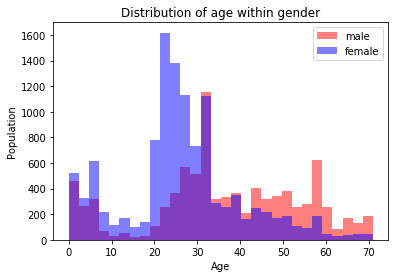

In [5]:
plt.hist(y_age_data[y_gender_data], bins=30, color='red', alpha=0.5, label='male')
plt.hist(y_age_data[~y_gender_data], bins=30, color='blue', alpha=0.5, label='female')
plt.legend()
plt.title('Distribution of age within gender')
plt.xlabel('Age')
plt.ylabel('Population')
plt.show()

# Seems that Dataset / Generator / Detector model may be biased

# Training a linear model for obtaining gender direction in latent space

In [6]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

In [7]:
%%time
# So let's find the gender direction in the latent space

clf = LogisticRegression(class_weight='balanced').fit(X_data, y_gender_data)
gender_direction = clf.coef_.reshape((18, 512))

# So yep, that's all. We made it.
# But let's do some research first. We'll pick that up later on.

CPU times: user 1min 30s, sys: 16.7 s, total: 1min 47s
Wall time: 1min 52s


### Evaluating model performance

In [8]:
# %%time
clf = SGDClassifier('log', class_weight='balanced') # SGB model for performance sake
scores = cross_val_score(clf, X_data, y_gender_data, scoring='accuracy', cv=5)
clf.fit(X_data, y_gender_data)
print(clf.feature_importances_)

print(scores)
print('Mean: ', np.mean(scores))

# Accuracy ? Meh. But gender distribution is almost balanced ... at least for simplicity sake

AttributeError: 'SGDClassifier' object has no attribute 'feature_importances_'

In [ ]:
print(clf.feature_importances_)

#### Dependency of gender detection errors on age 

In [ ]:
bins, bin_edges = np.histogram(y_age_data, bins=30)
errors,_ = np.histogram(y_age_data[clf.predict(X_data) != y_gender_data], bin_edges)

plt.plot(errors / bins)
plt.title('Dependency of gender detection errors on age')
plt.ylabel('Gender detection error rate')
plt.xlabel('Age')
plt.show()

# Seems that the most diffictul for model is to distinguish babies. For me as well to be honest.
# Or model which we used for creating "ground truth" produces random guesses
# I bet that both are true

#### Dependency of accuracy on training data size

In [ ]:
%%time

nb_folds = 5
splits = 20
scores = np.zeros((splits, nb_folds))
dataset_size = list()

for fold_id, (train_idx, test_idx) in enumerate(StratifiedKFold(nb_folds, True, 42).split(X_data, y_gender_data)):
    X_train, X_test = X_data[train_idx][:1000], X_data[test_idx]
    y_train, y_test = y_gender_data[train_idx][:1000], y_gender_data[test_idx]
    
    for split_id in range(splits):
        nb_samples = int((len(X_train)/splits) * (split_id+1))
        dataset_size.append(nb_samples)
        clf = SGDClassifier('log', class_weight='balanced').fit(X_train[:nb_samples], y_train[:nb_samples])
        scores[split_id][fold_id] = accuracy_score(y_test, clf.predict(X_test))
        

plt.plot(dataset_size[:splits], scores.mean(axis=1))
plt.title('Dependency of accuracy on training data size')
plt.xlabel('Dataset size')
plt.ylabel('Accuracy')
plt.show()

# Seems that 100 labeled examples is already enough to reach 80% accuracy (for gender).
# That's an interesting insight.

#### Latent layers importance

In [ ]:
# Let's try to find out which latent layer is most useful for predicting gender

scores = list()
for layer in tqdm_notebook(range(18)):
    clf = SGDClassifier('log', class_weight='balanced')
    scores.append(cross_val_score(clf, X_data.reshape((-1, 18, 512))[:,layer], y_gender_data, scoring='accuracy', cv=5).mean())
    
plt.plot(np.arange(0,18), scores)
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.show()

# Huh? Seems that every latent layer contains some information about gender.
# I didn't expect that to be honest.

# Visualization of gender transformation

In [ ]:
%%time
# Do you remember gender_direction ? 
# Anyway let's train it one more time

clf = LogisticRegression(class_weight='balanced')
clf.fit(X_data.reshape((-1, 18*512)), y_gender_data)
gender_dircetion = clf.coef_.reshape((18, 512))

In [ ]:
import PIL.Image
import dnnlib.tflib as tflib
from encoder.generator_model import Generator

URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((256, 256))

def move_and_show(latent_vector, direction, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
        ax[i].imshow(generate_image(new_latent_vector))
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()

In [ ]:
# For generating these face untruncated sampling was used

for i in range(10):
    move_and_show(X_data.reshape((-1, 18, 512))[i], gender_dircetion, [-5, -1.5, 0, 1.5, 5])

In [ ]:
donald_trump = np.load('ffhq_dataset/latent_representations/donald_trump_01.npy')
move_and_show(donald_trump, gender_dircetion, [-5, -1.5, 0, 1.5, 5])

In [ ]:
#
# Better approach for learning better representations is coming...some regularization magic is happening
#
# donald_trump = np.load('dark/deep/fantasy')
# move_and_show(donald_trump, gender_dircetion, [-5, -1.5, 0, 1.5, 5])

# - here is some images -

# Try to use some non-linear model

In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, Flatten, Activation
from keras.optimizers import SGD

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model.fit(X_data.reshape((-1, 18*512)), y_gender_data, validation_split=0.2, epochs=5)
model = Model(model.input, model.layers[-2].output)

# works bit better, but in general accuracy is quite similar to the linear model

In [ ]:
# some dark magic is happening here

embedding_model = Sequential()
embedding_model.add(Embedding(10, 18*512, input_length=1)) # it's actually just a variable
embedding_model.add(Flatten())

nonliner_gender_model = Model(embedding_model.input, model(embedding_model.output))
nonliner_gender_model.layers[-1].trainable = False # fix non-linear model and train only embeddings
nonliner_gender_model.compile('sgd', 'mse')

nonliner_gender_model.layers[1].set_weights([X_data[:10].reshape((-1, 18*512))])
y_data_real = nonliner_gender_model.predict(np.arange(10))
y_data_real

In [ ]:
# and here

nonliner_gender_model.fit(np.arange(10), np.full((10, 1), 20), verbose=0, epochs=500)
nonliner_gender_model.predict(np.arange(10))

In [ ]:
for v in embedding_model.layers[0].get_weights()[0]:
    plt.imshow(generate_image(v))
    plt.show()

In [ ]:
# reset latents and try it over but now in another direction 
nonliner_gender_model.layers[1].set_weights([X_data[:10].reshape((-1, 18*512))])

nonliner_gender_model.fit(np.arange(10), np.full((10, 1), -20), verbose=0, epochs=500)

for v in embedding_model.layers[0].get_weights()[0]:
    plt.imshow(generate_image(v))
    plt.show()

In [ ]:
# Did you expect that it's gonna work ? :)

# In general:
# 1) Instead of linear model we trained a non-linear model (two layers neural network) for predicting age
# 2) For a given latent vector we want to find a direction in non-linear space to become more male\female
# 3) Direction ? Sounds like we can use gradient descent...
# 4) So that's actually what we do, step by step we optimize latent vector to become more male\female